In [1]:
import torch
from IPython.display import display
from PIL import Image
from transformers import ColQwen2ForRetrieval, ColQwen2Processor
from peft import PeftModel


def get_torch_device(device: str = "auto") -> str:
    """
    Returns the device (string) to be used by PyTorch.

    `device` arg defaults to "auto" which will use:
    - "cuda:0" if available
    - else "mps" if available
    - else "cpu".
    """
    if device == "auto":
        if torch.cuda.is_available():
            device = "cuda:0"
        elif torch.backends.mps.is_available():  # for Apple Silicon
            device = "mps"
        else:
            device = "cpu"

    return device

def scale_image(image: Image.Image, new_height: int = 1024) -> Image.Image:
    """
    Scale an image to a new height while maintaining the aspect ratio.
    """
    # Calculate the scaling factor
    width, height = image.size
    aspect_ratio = width / height
    new_width = int(new_height * aspect_ratio)

    # Resize the image
    scaled_image = image.resize((new_width, new_height))

    return scaled_image

/home/linux/anaconda3/envs/cp_ft/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = get_torch_device("auto")

print(f"Using device: {device}")


# 加载 tokenizer 和基座模型
base_model_path = "/home/linux/yyj/colpali/finetune/colqwen2-v1.0-hf"
base_model = ColQwen2ForRetrieval.from_pretrained(
    base_model_path,
    torch_dtype=torch.bfloat16,
    device_map="cuda:0",
).eval()
# 加载微调后的 adapter（LoRA 权重）
adapter_path = "/home/linux/yyj/colpali/finetune/wiky_city_zh_0702_lr2e4_colqwen"
model = PeftModel.from_pretrained(base_model, adapter_path)
max_pixels = 1100*28*28
processor = ColQwen2Processor.from_pretrained(adapter_path, max_pixels=max_pixels)


Using device: cuda:0


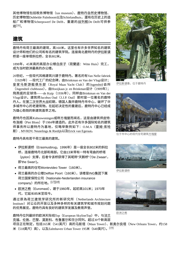

In [38]:
# Load the image and query inputs
image_filepath = "/home/linux/yyj/colpali/finetune/pdf2images/Rotterdam/page_008.png"

images = [Image.open(image_filepath)]

queries = ["鹿特丹的建筑有哪些？"]

# Preview the input images
for image in images:
    display(scale_image(image, 256))

In [39]:
# Preprocess inputs
batch_images = processor(images=image).to(model.device)
batch_queries = processor(text=queries).to(model.device)
print(batch_queries)
# Forward pass
with torch.no_grad():
    image_embeddings = model(**batch_images).embeddings
    query_embeddings = model(**batch_queries).embeddings
print(image_embeddings)
print(query_embeddings)

{'input_ids': tensor([[  2859,     25,  18137,    117,    123,  65278, 100721,   9370,  99893,
         104719,  11319, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
         151643, 151643, 151643]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}
tensor([[[ 0.0439, -0.0908, -0.0481,  ...,  0.0457, -0.0002,  0.1182],
         [ 0.0299, -0.1123, -0.0136,  ...,  0.0713, -0.0439, -0.1416],
         [ 0.0108, -0.1060, -0.0092,  ...,  0.0723, -0.0342, -0.1299],
         ...,
         [ 0.0574, -0.1338, -0.1006,  ...,  0.0430,  0.0581,  0.0522],
         [ 0.0430, -0.1377, -0.0300,  ...,  0.0264, -0.0226, -0.1338],
         [-0.0035, -0.0077, -0.0498,  ...,  0.0124,  0.1133, -0.1216]]],
       device='cuda:0', dtype=torch.bfloat16)
tensor([[[ 0.0552, -0.0942, -0.0491,  ...,  0.0496,  0.0132,  0.0962],
         [ 0.0002, -0.1108, -0.0109,  ...,  0.0625, -0.0256, -0.1387],
         [ 0.0172, -0.06

In [40]:
scores = processor.score_retrieval(query_embeddings, image_embeddings)  # (n_queries, n_images)

scores

tensor([[14.9375]], dtype=torch.bfloat16)

In [41]:
import pprint
from typing import Tuple

import matplotlib.pyplot as plt
from colpali_engine.interpretability import (
    get_similarity_maps_from_embeddings,
    plot_all_similarity_maps,
    plot_similarity_map,
)
from transformers import BatchFeature, ProcessorMixin
from transformers.models.qwen2_vl.image_processing_qwen2_vl import smart_resize


def get_n_patches(
    processor: ColQwen2Processor,
    image_size: Tuple[int, int],
    spatial_merge_size: int,
) -> Tuple[int, int]:
    """
    Get the number of patches created by the processor along each dimension of the image.
    """
    patch_size = processor.image_processor.patch_size

    height_new, width_new = smart_resize(
        width=image_size[0],
        height=image_size[1],
        factor=patch_size * processor.image_processor.merge_size,
        min_pixels=processor.image_processor.size["shortest_edge"],
        max_pixels=processor.image_processor.size["longest_edge"],
    )

    n_patches_x = width_new // patch_size // spatial_merge_size
    n_patches_y = height_new // patch_size // spatial_merge_size

    return n_patches_x, n_patches_y


def get_image_mask(processor: ProcessorMixin, batch_images: BatchFeature) -> torch.Tensor:
    """
    Get a tensor mask that identifies the image tokens in the batch.
    """
    image_token_id = processor.tokenizer.convert_tokens_to_ids(processor.image_token)
    return batch_images.input_ids == image_token_id

In [42]:
from typing import List
# Get the number of patches and the image mask for each image of the batch
batched_n_patches: List[Tuple[int, int]] = []  # [(n_patches_x, n_patches_y), ...]


n_patches = get_n_patches(
    processor=processor,
    image_size=image.size,
    spatial_merge_size=model.vlm.config.vision_config.spatial_merge_size,
)
batched_n_patches.append(n_patches)

image_mask = get_image_mask(processor=processor, batch_images=batch_images)

# Batch-compute the similarity maps
batched_similarity_maps = get_similarity_maps_from_embeddings(
    image_embeddings=image_embeddings,
    query_embeddings=query_embeddings,
    n_patches=batched_n_patches,
    image_mask=image_mask,
)

print("For the first image:")
print(f"  - Number of image patches: {batched_n_patches[0]}")
print(f"  - Similarity map shape: (query_length, n_patches_x, n_patches_y) = {tuple(batched_similarity_maps[0].shape)}")

For the first image:
  - Number of image patches: (27, 39)
  - Similarity map shape: (query_length, n_patches_x, n_patches_y) = (21, 27, 39)


In [43]:
idx = 0
input_ids = batch_queries.input_ids[idx]   # 25 Tensor of shape (L,)
all_tokens = processor.tokenizer.convert_ids_to_tokens(input_ids)
# 过滤掉 pad 和 augmentation tokens，保留 (index, id) 对
pad_tok = processor.tokenizer.pad_token_id
aug_tok = processor.query_augmentation_token  # 如果 processor 里有对应 .id 属性
print(f'pad: {pad_tok}, aug: {aug_tok}')
filtered = [
    (i, input_ids[i].item())
    for i in range(len(input_ids))
    if input_ids[i].item() not in {pad_tok, aug_tok}
]
print(filtered)
# 打印下标 & 真正解码出的字符
for i, tok_id in filtered:
    char = processor.tokenizer.decode([tok_id], clean_up_tokenization_spaces=True)
    print(f"{i:3d} -> id={tok_id:5d} -> '{char}'")


pad: 151643, aug: <|endoftext|>
[(0, 2859), (1, 25), (2, 18137), (3, 117), (4, 123), (5, 65278), (6, 100721), (7, 9370), (8, 99893), (9, 104719), (10, 11319)]
  0 -> id= 2859 -> 'Query'
  1 -> id=   25 -> ':'
  2 -> id=18137 -> ' �'
  3 -> id=  117 -> '�'
  4 -> id=  123 -> '�'
  5 -> id=65278 -> '特'
  6 -> id=100721 -> '丹'
  7 -> id= 9370 -> '的'
  8 -> id=99893 -> '建筑'
  9 -> id=104719 -> '有哪些'
 10 -> id=11319 -> '？'


In [44]:
# While all similarity maps are computed, we will only visualize the idx-th one
idx = 0
similarity_maps = batched_similarity_maps[idx]  # (query_length, n_patches_x, n_patches_y)

# Remove the padding tokens and the query augmentation tokens
query_content = processor.decode(batch_queries.input_ids[idx])
query_content = query_content.replace(processor.tokenizer.pad_token, "")
query_content = query_content.replace(processor.query_augmentation_token, "").strip()
print(query_content)
# Retokenize the cleaned query
query_tokens = processor.tokenizer.tokenize(query_content)

# Use this cell output to choose a token using its index
pprint.pprint({idx: val for idx, val in enumerate(query_tokens)})

Query: 鹿特丹的建筑有哪些？
{0: 'Query',
 1: ':',
 2: 'Ġé',
 3: '¹',
 4: '¿',
 5: 'çī¹',
 6: 'ä¸¹',
 7: 'çļĦ',
 8: 'å»ºçŃĳ',
 9: 'æľīåĵªäºĽ',
 10: 'ï¼Ł'}


Selected token: `å»ºçŃĳ`


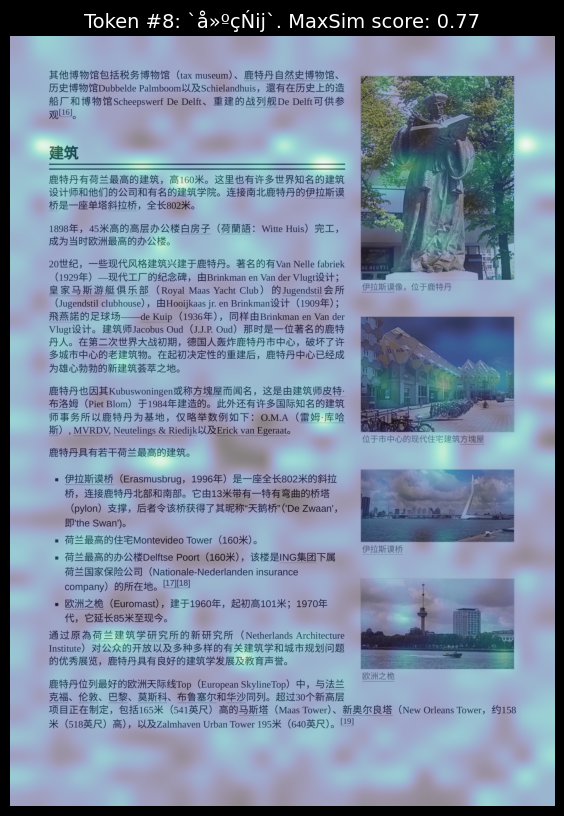

In [46]:
# Choose a token using its index
token_idx = 8  # e.g. if "20: 'Ġmer',", set to 20 to choose the token 'Ġmer'

print(f"Selected token: `{query_tokens[token_idx]}`")

# Retrieve the similarity map for the chosen token
current_similarity_map = similarity_maps[token_idx]  # (n_patches_x, n_patches_y)

fig, ax = plot_similarity_map(
    image=images[0],
    similarity_map=current_similarity_map,
    figsize=(8, 8),
    show_colorbar=False,
)

max_sim_score = similarity_maps[token_idx, :, :].max().item()
ax.set_title(f"Token #{token_idx}: `{query_tokens[token_idx]}`. MaxSim score: {max_sim_score:.2f}", fontsize=14)

fig